In [25]:
import array as arr
from BTrees.IIBTree import IIBTree # documentation, https://pythonhosted.org/BTrees/ 
import csv
# import queue    # see https://docs.python.org/3/library/queue.html#module-queue
import math
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import matplotlib.pyplot as plt
# from matplotlib.collections import Poly3DCollection # https://stackoverflow.com/questions/10599942/drawing-a-rectangle-or-bar-between-two-points-in-a-3d-scatter-plot-in-python-and
# and https://stackoverflow.com/questions/37585340/plotting-3d-polygons-in-python-3
import numpy as np
from trajectory import * # import the trapezoidal trajectory
import time

# interesting/useful websites
# talks about implementing robot simulator: https://www.toptal.com/robotics/programming-a-robot-an-introductory-tutorial  
#    said robot simulator code: https://github.com/nmccrea/sobot-rimulator/blob/v1.0.0/models/supervisor.py

In [26]:
def step(t, dt):
    t = t + dt
    return t

In [69]:
class drawRobot(object):
    def __init__(self):
        self.a = 0
        
    def drawRect(self, q_curr, width_v, length_v):

        xl  = q_curr[0] + width_v / 2  # left x coordinate
        xr  = q_curr[0] - width_v / 2  # right x coordinate

        yf  = q_curr[1] - length_v / 2 # front
        yb  = q_curr[1] + length_v / 2 # back

        verts = []

        xs = [xr, xl, xl, xr, xr]  # each box has 4 vertices, give it 5 to close it, these are the x coordinates
        ys = [yf, yf, yb, yb, yf]  # each box has 4 vertices, give it 5 to close it, these are the y coordinates
        z_axis = [0, 0, 0, 0, 0]

        verts = [list(zip(xs, ys, z_axis))]

        poly = Poly3DCollection(verts, facecolors="blue", closed = False)
        ax.add_collection3d(poly, zs=[z_axis[0]] * len(verts), zdir='z')
        
        
    def drawFrame(self, left_edge, back_edge, front_edge, z_edges_f):
        xl  = left_edge  # back x coordinate
        
        yf  = front_edge # front y coordinate
        yb  = back_edge  # back y coordinate

        zt  = z_edges_f[0]  # top z coordinate
        zb  = z_edges_f[1]  # bottom z coordinate

        verts = []
        
        xs = [xl, xl, xl, xl, xl]
        ys = [yf, yb, yb, yf, yf]  # each box has 4 vertices, give it 5 to close it, these are the x coordinates
        z_axis = [zt, zt, zb, zb, zt]  # each box has 4 vertices, give it 5 to close it, these are the y coordinates
        
        verts = [list(zip(xs, ys, z_axis))]

        poly = Poly3DCollection(verts, facecolors="grey", closed = False)
        ax.add_collection3d(poly, zs=[z_axis[0]] * len(verts), zdir='z')

In [70]:
def vehicleStep(q_curr, v, dt):
    # for now it's constant velocity  
    q_new = np.array([q_curr[0] + v[0]*dt, q_curr[1] + v[1]*dt])
    return q_new

In [71]:
class camera(object):
    def __init__(self, length_v, n_row, frame_height):      
        
        #################### CLASS VARIABLES ####################
        self.width = length_v  # width of camera view, in m
        self.i_lastFruit = 0   # last visited fruit index
        
        # lists of coordinates of picked fruits
        self.x      = []
        self.y      = []
        self.z      = []
        self.t_pick = []        # time when fruit was picked
        
        # Settings for the row
        self.row_n  = n_row     # row number, in one sided-version, lower number means lower on the vehicle
        self.height = frame_height # how high of fruit can this row see

        self.mid_location = (  # tuple used to determine the location of the middle of the row
            self.height/2,
            self.height + self.height/2,
            2*self.height + self.height/2
        )
        
        self.row_mid = self.mid_location[self.row_n] # find the row height for this arm => might not need self

        # calculate the vertical edges of the frame once
        self.view_min_h = self.row_mid - self.height / 2 # up-down edges
        self.view_max_h = self.row_mid + self.height / 2
        
        print("top:", self.view_max_h, "bottom:", self.view_min_h)


        ######################## MODULES ########################
        self.fruitBTree    = IIBTree()
        
               
        
    ######################## FUNCTIONS ########################
    def cameraStep(self, end_row, q_curr, sortedFruit):
        # centered (for now) on the vehicle, perpendicular to data's y-axis
        view_min = q_curr - self.width / 2 # side edges
        view_max = q_curr + self.width / 2
        
        # fix side end constraints of beginning and end 
        if view_min < 0:
            view_min = 0

        if view_max > end_row:
            view_max = end_row
            
        j = self.i_lastFruit # the last fruit that was added (so it repeats less)
            
        # do the same but updating a b-tree instead for better searchability
        while(True):
            if sortedFruit[1,j] > view_min and sortedFruit[1,j] < view_max:
                # now check vertical edges
                if sortedFruit[2,j] > self.view_min_h and sortedFruit[2,j] < self.view_max_h:
                    # now check if it has been picked before
                    if sortedFruit[3,j] == 0:
                        # convert the y-location into an integer so it can be used as a key, ceiling because it's at the edge
                        # so it can't really be used either way as a goal
                        key = math.ceil(sortedFruit[1,j]*1000) 
                        # add the value to the b-tree
                        self.fruitBTree.update({key:j})
                
            elif sortedFruit[1,j] > view_max:
                # no fruit left to add
                break
            j = j + 1
            
        ## delete fruit that's behind the vehicle => put in a seperate set
        # can use it to figure out what speed the vehicle should go => number of fruits left behind.
            
        self.i_lastFruit = j
    
    
    def fruitPicked(self, pointCoord, t):
        self.x.append(float(pointCoord[0]))
        self.y.append(float(pointCoord[1]))
        self.z.append(float(pointCoord[2]))
        self.t_pick.append(float(t))
        
        
    def packFruit(self):
        x_fr = np.array(self.x)
        y_fr = np.array(self.y)
        z_fr = np.array(self.z)
        t    = np.array(self.t_pick)

        # need a matrix to sort x, y, and z based on the y-axis (to know what fruit show up earlier)
        inv_fruit = np.stack([x_fr, y_fr, z_fr, t])
        
        return inv_fruit
        


In [72]:
# def schedule(indexVisFruit):
    # start simple by just popping out the next value (see if we can do this)
#     i_goal = indexVisFruit.get()
#     print(i_goal)

In [81]:
class arm(object):
    def __init__(self, q, n, frame_width, frame_height, row_n):
        
        ## next level would be for them to be seperate threads with access to the global clock
              
        #################### CLASS VARIABLES ####################
        self.n             = n                           # arm number 
        self.row_n         = row_n                       # which row this arm is located in
        self.q_a           = np.array([q[0],q[1],q[2]])  # arm's location in the world's frame of reference
#         self.q_zero        = np.array([q[0],q[1],q[2]])  # arm's zero location (can go back to it)
        self.v_a           = np.array([0.,0.,0.])        # arm's current velocity in the three axis
        
        # list of all locations where arm was
        self.qax           = []
        self.qay           = []
        self.qaz           = []
        
        self.length_f      = 4.5          # how far can it go into trees, in m
        self.width_f       = frame_width  # size of enclosing frame, width in m
        self.height_f      = frame_height # size of enclosing frame, height in m
        
        # frame center coordinates
        self.q_f           = np.array([self.q_a[0],self.q_a[1],self.q_a[2]])  # frame's location in the world's frame of reference
        # edges of the frame
        self.x_edges_f     = np.array([0.,0.])
        self.y_edges_f     = np.array([0.,0.])
        self.z_edges_f     = np.array([0.,0.])
        
        # values for trapezoid trajectory (parameters to play with...)
        self.v_max         = 1.
        self.a_max         = 10. 
        self.d_max         = 10.
        
        # can the arm be given a goal, or does it already have one
        self.free          = 1     # start ready to be given a goal 
        self.goal          = np.array([0.,0.,0.])
        self.goal_r        = np.array([0,0,0]) # has the goal been rached at each axis
        self.reached_goals = 0     # how many goals were successfully reached 
        
        # Flags
        self.x_move        = 0     # allows the x-dir to start moving
        self.retractFlag   = 0     # checks if the arm is retracting
        
        # following the trapezoidal trajectory
        self.t             = 0.      # time at which the arm will begin moving to the goal
        self.tx            = 0.      # time at which the arm will begin moving in the x-dir
        
        # calculate the error between the final location and given goal coordinates 
        self.error         = np.array([0.,0.,0.])
        
        ######################## MODULES ########################
        self.x = Trajectory(self.v_max, self.a_max, self.d_max)
        self.y = Trajectory(self.v_max, self.a_max, self.d_max)
        self.z = Trajectory(self.v_max, self.a_max, self.d_max)
        
        ################ SELF FUNCTIONS AT INIT #################
        self.initFrame()
        
        
    ######################## FUNCTIONS ########################
    def armStep(self, v_v, dt, t):
        # AAAALLLLL THE AAARMMMSSSSSSSSS
        # v_v is the vehicle's velocity
        # q_curr is the arm's current location within the world frame 
        q_curr      = np.array([self.q_a[0],self.q_a[1],self.q_a[2]])

        goal_time   = t - self.t      # time since the y-z self timer was started
        goal_time_x = t - self.tx     # time since the x self timer was started => not updating correctly
        
        can_reach   = 0               # start with the possibility that a fruit cannot be reached
        epsilon     = 0.001           # allowable error when reaching fruit 
    
        # move along with the vehicle
        self.moveFrame(v_v, dt)       # start with the frame
        
        # check if fruit can still be reached according to frame's location 
        can_reach   = self.reachable()
        
        if can_reach == 1:
            # at the moment trying to cancel the vehicle's velocity/movement's effect on the arms by subtracting it
            # in the y-axis:
            self.calcYVel(goal_time, v_v)
            # in the z-axis:  
            self.calcZVel(goal_time)  # not affected by the vehicle's velocity

            # if both y and z goal locations reached, start moving in the x-dir to grab the fruit
            if self.goal_r[1] == 1 and self.goal_r[2] == 1:
                # check that it's the first time this has been reached since a new goal was given
                if self.tx == 0.:        
                    self.tx     = t   # start time for the new timer for x
                    goal_time_x = 0.  # restart the timer for x
                    self.x_move = 1   # allow movement in the x-direction

            if self.x_move == 1: 
                self.calcXVel(goal_time_x, v_v)
              
        elif can_reach == 0:
            # set these at zero and check if arm has to be retracted
            self.v_a[1] = 0
            self.v_a[2] = 0
            if self.retractFlag == 1: 
#                 print("THE ARRRMMMMMMSSSSS")
#                 print("THEY RETRACT?", self.retractFlag)
#                 print("GOOOOAL", goal_time_x)
                self.calcXVel(goal_time_x, v_v)
#                 print("AND AFTER?", self.retractFlag)
        
        self.q_a[0] = q_curr[0] + self.v_a[0]*dt + v_v[0]*dt # coordinate affected by the vehicle's speed (need to change to reflect the axis)
        self.q_a[1] = q_curr[1] + self.v_a[1]*dt + v_v[1]*dt # coordinate affected by the vehicle's speed
        self.q_a[2] = q_curr[2] + self.v_a[2]*dt 
        
        # check if goal was actually reached
#         if (self.q_a[0] + epsilon < self.goal[0]) or (self.q_a[0] - epsilon > self.goal[0]) and self.goal_r[0] == 1: 
#             self.goal_r[0] = 0
            
#         if (self.q_a[1] + epsilon < self.goal[1]) or (self.q_a[1] - epsilon > self.goal[1]) and self.goal_r[1] == 1: 
#             self.goal_r[1] = 0
            
#         if (self.q_a[2] + epsilon < self.goal[2]) or (self.q_a[2] - epsilon > self.goal[2]) and self.goal_r[2] == 1: 
#             self.goal_r[2] = 0
            
        # update the zero location to follow the vehicle
#         self.q_zero[0] += v_v[0]*dt
#         self.q_zero[1] += v_v[1]*dt
        
        # stop the arm from extending backwards beyond the back of the frame
        if self.q_a[0] < self.q_f[0]:
            self.q_a[0] = self.q_f[0]
        
        # update the location history (for plotting :) ) 
        self.qax.append(float(self.q_a[0]))
        self.qay.append(float(self.q_a[1]))
        self.qaz.append(float(self.q_a[2]))
        
        if self.q_a[0] < self.q_f[0]- 0.001:  
            print("")
            print("ARM:", self.n, "ROW:", self.row_n)
            print("edges in X:", self.x_edges_f, "edges in Y:", self.y_edges_f, "edges in Z:", self.z_edges_f)

            print("goal:         {0:.4f}".format(self.goal[0]), " {0:.4f}".format(self.goal[1]), " {0:.4f}".format(self.goal[2]))
            print("arm location: {0:.4f}".format(self.q_a[0]), " {0:.4f}".format(self.q_a[1]), " {0:.4f}".format(self.q_a[2]))

#         print("")
#         print("Goals reached:", self.goal_r)
#         print("retracting:", self.retractFlag)
#         print("can it reach?:", can_reach)
#         print("")
 
        # check if the goal was reached within +/- some error ((correct and fixed, don't touch unless proof of mistake))
        if (self.goal_r[0] == 1 and self.goal_r[1] == 1 and self.goal_r[2] == 1):
            if ((self.q_a[0] > (self.goal[0]-epsilon) and self.q_a[0] < (self.goal[0]+epsilon)) and
                (self.q_a[1] > (self.goal[1]-epsilon) and self.q_a[1] < (self.goal[1]+epsilon)) and
                (self.q_a[2] > (self.goal[2]-epsilon) and self.q_a[2] < (self.goal[2]+epsilon))):
                # find a better way to do this?
                self.reached_goals += 1
#                 print("GOAL REACHED")
                # "pick" the fruit
                row_picture[self.row_n].fruitPicked(self.q_a, t)
        
        # if goal has been reached or the fruit cannot be reached, set free to one so a new goal can be given
        if (self.goal_r[0] == 1 and self.goal_r[1] == 1 and self.goal_r[2] == 1) or can_reach == 0:
            # retract the arm if needed 
            if (self.q_a[0] > self.q_f[0]+epsilon or self.q_a[0] < self.q_f[0]-epsilon) and self.retractFlag == 0: # not equal
                self.retract()
                # restart the x timers
                self.tx     = t      # start time for the new timer for x
                goal_time_x = 0.
                
            elif self.retractFlag == 0:
                self.tx        = 0.
                self.free      = 1 
                self.x_move    = 0
                # restart the goal reached values for all axis when new goal is given
                self.goal_r[0] = 0
                self.goal_r[1] = 0
                self.goal_r[2] = 0
        
        return self.q_a
    

    def retract(self):
        # retracts the arm 
        self.x.adjInit(self.q_a[0], 0)
        self.x.noJerkProfile(self.q_a[0], self.q_f[0], self.x.v0, self.v_max, self.a_max, self.d_max)
        
        if self.q_a[0] < self.q_f[0]- 0.001:
            print(" ")
            print("RETRACTING")
            print("ARM:", self.n, "ROW:", self.row_n)
            print("X-axis, Ta:", self.x.Ta, "Tv:", self.x.Tv, "Td:", self.x.Td)      
            print(" ")
            print("goal:         {0:.4f}".format(self.goal[0]), " {0:.4f}".format(self.goal[1]), " {0:.4f}".format(self.goal[2]))
        
        self.retractFlag = 1
    
    
    def setGoal(self, goal, t):
        self.free = 0
        self.goal = goal
        
        self.x.adjInit(self.q_a[0], 0) # init each axis with current location and velocity (will need velocity at some point)   
        self.y.adjInit(self.q_a[1], 0) 
        self.z.adjInit(self.q_a[2], 0)
        
        self.trapTimes()
            
        # maybe start time here? => evalulate how that could change things once in real time
        self.t = t
        
        
    def trapTimes(self):
        # get trapezoidal times
        self.x.noJerkProfile(self.x.q0, self.goal[0], self.x.v0, self.v_max, self.a_max, self.d_max) 
        self.y.noJerkProfile(self.y.q0, self.goal[1], self.y.v0, self.v_max, self.a_max, self.d_max)  
        self.z.noJerkProfile(self.z.q0, self.goal[2], self.z.v0, self.v_max, self.a_max, self.d_max)  
        
        print(" ")
        print("X-axis, Ta:", self.x.Ta, "Tv:", self.x.Tv, "Td:", self.x.Td)
        print("Y-axis, Ta:", self.y.Ta, "Tv:", self.y.Tv, "Td:", self.y.Td)
        print("Z-axis, Ta:", self.z.Ta, "Tv:", self.z.Tv, "Td:", self.z.Td) 
        print(" ")
        print("reached values, X:", self.x.vr, self.x.ar, self.x.dr)
        print("reached values, Y:", self.y.vr, self.y.ar, self.y.dr)
        print("reached values, Z:", self.z.vr, self.z.ar, self.z.dr)        
        print(" ")
        # as more arms are added, these might need to be made internal to the object
       
    
    def initFrame(self):
        # calculate the edges of the frame
        # the x-dir edge is more of a limit on the extension capabilities of the arm. so it's not symetrical
        self.x_edges_f[0] = self.q_f[0]
        self.x_edges_f[1] = self.q_f[0] + self.length_f
        
        # the y-dir edge moves along with the vehicle's movement
        self.y_edges_f[0] = self.q_f[1] + self.width_f / 2
        self.y_edges_f[1] = self.q_f[1] - self.width_f / 2
        
        # the height will stay constant throughout
        self.z_edges_f[0] = self.q_f[2] + self.height_f / 2
        self.z_edges_f[1] = self.q_f[2] - self.height_f / 2
    
    
    def moveFrame(self, v_v, dt):
        x_coor = self.q_f[0]
        y_coor = self.q_f[1]
        
        left_edge  = self.x_edges_f[0]
        right_edge = self.x_edges_f[1]
        front_edge = self.y_edges_f[0]
        back_edge  = self.y_edges_f[1]
        
        # move the center point as the vehicle moves
        self.q_f[0] = x_coor + v_v[0]*dt
        self.q_f[1] = y_coor + v_v[1]*dt
        
        # move the edges
        self.x_edges_f[0] = left_edge + v_v[0]*dt
        self.x_edges_f[1] = right_edge + v_v[0]*dt
        
        self.y_edges_f[0] = front_edge + v_v[1]*dt
        self.y_edges_f[1] = back_edge + v_v[1]*dt
       
    
    def reachable(self):
        # check if the fruit is reachable now or in the "future" => actually, should use trapezoidal calc
        # to see if it can reach. ==> not true. Because the vehicle's speed will be variable, these calculations 
        # will very likely be wrong
        
        if self.goal[0] < self.x_edges_f[1] and self.goal[1] > self.y_edges_f[1]:
            # check if the goal is passed the edge of the back frame
            
            # don't need to check the y frame because no goals that pass it can be given (already limited by camera object)
            return 1

#             if self.goal[2] < self.z_edges_f[0] and self.goal[2] > self.z_edges_f[1]:
#                 # check again if the goal is within the top and bottom of the frame
#                 return 1
#             else:
#                 return 0
        else:
            return 0 
        
    
    def calcXVel(self, goal_time_x, v_v):
        if goal_time_x <= self.x.Ta:
            self.v_a[0] = self.x.v0 + self.x.ar*goal_time_x - v_v[0]
            
        elif goal_time_x <= self.x.Ta + self.x.Tv:
            self.v_a[0] = self.x.vr - v_v[0]
            
        elif goal_time_x <= self.x.Ta + self.x.Tv + self.x.Td:
            self.v_a[0] = self.x.vr - self.x.dr*(goal_time_x - (self.x.Ta + self.x.Tv)) - v_v[0]
        
        else:
            self.v_a[0] = -v_v[0] # cancel the vehicle's motion while waiting to grab the fruit
            self.goal_r[0] = 1
            self.retractFlag = 0
            
    
    def calcYVel(self, goal_time, v_v):
        if goal_time <= self.y.Ta:
            self.v_a[1] = self.y.v0 + self.y.ar*goal_time - v_v[1]
            
        elif goal_time <= self.y.Ta + self.y.Tv:
            self.v_a[1] = self.y.vr  - v_v[1]
            
        elif goal_time <= self.y.Ta + self.y.Tv + self.y.Td:
            self.v_a[1] = self.y.vr - self.y.dr*(goal_time - (self.y.Ta + self.y.Tv))  - v_v[1]
        
        else:
            self.v_a[1] = -v_v[1] # cancel the vehicle's motion while waiting to grab the fruit
            self.goal_r[1] = 1
            
            
    def calcZVel(self, goal_time):
        if goal_time <= self.z.Ta:
            self.v_a[2] = self.z.v0 + self.z.ar*goal_time

        elif goal_time <= self.z.Ta + self.z.Tv:
            self.v_a[2] = self.z.vr

        elif goal_time <= self.z.Ta + self.z.Tv + self.z.Td:
            self.v_a[2] = self.z.vr - self.z.dr*(goal_time - (self.z.Ta + self.z.Tv))
        else:
            self.v_a[2] = 0.
            self.goal_r[2] = 1
        
        
    def calcError(self):
        # Calculate the error between the final location and the given goal coordinates for the arm
        self.error[0] = (self.goal[0] - self.q_a[0]) / self.goal[0]
        self.error[1] = (self.goal[1] - self.q_a[1]) / self.goal[1]
        self.error[2] = (self.goal[2] - self.q_a[2]) / self.goal[2]
    

In [82]:
class csvRead(object):
    def __init__(self):
        #################### CLASS VARIABLES ####################
        
        
        # open CSV file and populate fruits on grid
        x_fr = []
        y_fr = []
        z_fr = []

        # with open('Applestotheleft.csv', newline='') as csvfile:
        #     spamreader = csv.reader(csvfile, delimiter=',', quotechar='|')
        #     for row in spamreader:
        #         x_fr.append(float(row[0]))
        #         y_fr.append(float(row[1]))
        #         z_fr.append(float(row[2]))

        with open('Applestotheright.csv', newline='') as csvfile:
            spamreader = csv.reader(csvfile, delimiter=',', quotechar='|')
            for row in spamreader:
                x_fr.append(float(row[0]))
                y_fr.append(float(row[1]))
                z_fr.append(float(row[2]))

        self.x_fruit = np.array(x_fr)
        self.y_fruit = np.array(y_fr)
        self.z_fruit = np.array(z_fr)
        picked  = np.zeros(len(self.x_fruit))

        # need a matrix to sort x, y, and z based on the y-axis (to know what fruit show up earlier)
        fruit = np.stack([x_fr, y_fr, self.z_fruit, picked])

        rowIndex = 1 # sort based on y-axis
        self.sortedFruit = fruit[ :, fruit[rowIndex].argsort()]

#         return sortedFruit


In [83]:
# init environment
noise = 0.     # for when it becomes stochastic
end_row = 15.  # end of the row
t = []         # 'global' time
t_new = 0.
dt = 0.01      # 'global' time step size
runs = 0

fruit = csvRead()

dr = drawRobot()

In [84]:
# init vehicle
num_arms     = 3                 # set number of arms on robot, will determine the length of the robot (for now)
### above might turn into number of arms per row, not per robot?
num_row_arms = 3                 # set the number of rows of arms. Getting it ready to add when one row works
frame_width  = 3.                # set the arm's frame's width along y-axis 
frame_height = 3.                # set the height of the arm's frame

width_v = 1.                     # vehicle width (x-dir, parallel to arms going into canopy)
length_v = frame_width*num_arms  # vehicle length (y-dir parallel to row of trees)

q_v = np.array([6.3,9.])         # starting location
v_v = np.array([0.,0.003])       # in m, constant velocity

qv0 = []
qv1 = []

In [85]:
# init camera, one for each row!
row_picture = []

for rows in range(num_row_arms):
    p = camera(length_v, rows, frame_height)
    row_picture.append(p)
    
# picture = camera(length_v)

top: 2.5 bottom: 0.0
top: 5.0 bottom: 2.5
top: 7.5 bottom: 5.0


In [86]:
# init scheduler
goal = np.zeros(3) # does this go here?

In [87]:
# init arms
# get 0th arm's center point on y-axis
arm0start_y = q_v[1] - (length_v - frame_width)/2
# set location for 0th arm
q_a     = np.array([q_v[0],arm0start_y,4]) # location of arm in vehicle frame? => need to figure out how to set these when there are >1 arms
q_a_new = np.array([0.,0.,0.]) 

a = np.ndarray((num_row_arms,num_arms), dtype=object)

# for each row
for rows in range(num_row_arms):       
    # initialize the arms in a list
    for count in range(num_arms):      
        # calculate where each new arm should go
        q_a_new[0] = q_a[0]             # doesn't change right now
        q_a_new[1] = q_a[1] + frame_width*count  # place it next to the previous arm
        q_a_new[2] = row_picture[rows].row_mid   # place it in the already calculated middle of the row
        # initialize the new arm 
        x = arm(q_a_new, count, frame_width, frame_height, rows)
        # add the arm to the a-list     
        a[rows,count] = x
        
    
## the different levels of arms might start at different distances from the frame (cause fruit farther away)
# maybe have a configuration file that would initialize the arms 

# for plotting
left_edge  = []
right_edge = []
front_edge = []
back_edge  = []


In [88]:
## start timer to see how long code takes to execute
start_time = time.time()

##### while loooop!
while(q_v[1] < end_row):
    # env.step
    t_new = step(t_new, dt)
    t.append(float(t_new))
    
    
    # vehicle.step 
    q_v = vehicleStep(q_v, v_v, dt) # calculate "instantaneous" location
    
    
    # env.obs / camera... FLASH!
#     picture.cameraStep(end_row, q_v[1], sortedFruit) # resulting in a B-Tree of index/coordinates in world frame  
    for rows in range(num_row_arms):
        row_picture[rows].cameraStep(end_row, q_v[1], fruit.sortedFruit) # resulting in a B-Tree of index/coordinates in world frame  
    
    
    if (noise == 1):
        # add some noissse! (to the fruit locations)
        noise = 0 # but not right now
    
    ## create a function/class of the greedy assignment algorithm 
    # more general fruit to arm assignment (do more of the fruit per arm at the same time)
    
    # schedule
    # for each row
    for rows in range(num_row_arms):
        # check if there are any arms that are free 
        for arm_free in range(num_arms):
#             if a[arm_free].free == 1 and len(picture.fruitBTree) > 0:
            if a[rows,arm_free].free == 1 and len(row_picture[rows].fruitBTree) > 0:
                # get the location of this arm's back edge and convert to integer to get a value to compare keys
                
                potential_key = math.floor(a[rows,arm_free].y_edges_f[1]*1000) #+2
                # find a value in the B-tree that fits it's location 
                try: # if no key exists after the potential key, break out rather than crash the program
                    key = row_picture[rows].fruitBTree.minKey(potential_key)
                    index = row_picture[rows].fruitBTree[key]
                    
                    # check that the goal does not pass the front part of the frame
                    if fruit.sortedFruit[1,index] < a[rows,arm_free].y_edges_f[0]+1:
                        # choose the first fruit as a goal to be given to the arm
    #                     goal_new = picture.fruitBTree.pop(key)
                        goal_new = row_picture[rows].fruitBTree.pop(key)
                        # set the index's fruit as picked
                        fruit.sortedFruit[3,goal_new] = 1 
                        # set the new goal
                        a[rows,arm_free].setGoal(fruit.sortedFruit[0:3,goal_new], t_new)
                        ### make sure there are available goals left in the b-tree at some point
                    
                except ValueError:
                    print("*** No value came up, broke out of the if statement ***")
                    break

                ## look into B-Trees 
                ## https://ebrary.net/25936/computer_science/b-tree_organization
                ## https://cstack.github.io/db_tutorial/parts/part7.html

                ## what happens when there are gaps between trees/fruits => right now it would freeze? => maybe not...
                ## => right now they freeze when they hit that 

    
    # have each arm take a step
    for rows in range(num_row_arms):
        for arm2step in range(num_arms):
            q_a = a[rows,arm2step].armStep(v_v, dt, t_new)

#    # when the vehicle is stopped, gives an end to the while loop
#     if a1.error[1] == math.inf or a1.error[1] == -math.inf:
#         print("end of the fruit in y")
#         break
    
#     if a1.error[2] == math.inf or a1.error[2] == -math.inf:
#         print("end of the fruit in z")
#         break
    
    # plotting data     
    qv0.append(float(q_v[0]))
    qv1.append(float(q_v[1]))
    
    left_edge.append(float(a[0,0].x_edges_f[0]))
    front_edge.append(float(a[0,0].y_edges_f[0]))
    back_edge.append(float(a[0,0].y_edges_f[1]))
               
    runs+=1

    
prog_time = time.time() - start_time

start, end, start velocity: 6.3 9.8678696059 0
start, end, start velocity: 6.0 5.3231695488 0
start, end, start velocity: 1.25 1.1919865482 0
 
X-axis, Ta: 0.1 Tv: 3.4678696058999994 Td: 0.1
Y-axis, Ta: 0.1 Tv: 0.5768304511999999 Td: 0.1
Z-axis, Ta: 0.07616656208599673 Tv: 0 Td: 0.07616656208599673
 
reached values, X: 1.0 10.0 10.0
reached values, Y: -1.0 -10.0 -10.0
reached values, Z: -0.7616656208599674 -10.0 -10.0
 
start, end, start velocity: 6.3 9.9191284757 0
start, end, start velocity: 9.0 7.5732524703 0
start, end, start velocity: 1.25 1.4549112491 0
 
X-axis, Ta: 0.1 Tv: 3.519128475699999 Td: 0.1
Y-axis, Ta: 0.1 Tv: 1.3267475297 Td: 0.1
Z-axis, Ta: 0.1 Tv: 0.10491124910000002 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached values, Y: -1.0 -10.0 -10.0
reached values, Z: 1.0 10.0 10.0
 
start, end, start velocity: 6.3 9.0836432909 0
start, end, start velocity: 12.0 10.794768294 0
start, end, start velocity: 1.25 0.9577824011 0
 
X-axis, Ta: 0.1 Tv: 2.6836432908999996 Td: 0.1

start, end, start velocity: 6.3 7.6108578398 0
start, end, start velocity: 6.120163235263975 6.136835866 0
start, end, start velocity: 6.052743511699188 5.3244889034 0
 
X-axis, Ta: 0.1 Tv: 1.2108578398000005 Td: 0.1
Y-axis, Ta: 0.04083213285639753 Tv: 0 Td: 0.04083213285639753
Z-axis, Ta: 0.1 Tv: 0.6282546082991886 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 0.4083213285639753 10.0 10.0
reached values, Z: -1.0 -10.0 -10.0
 
start, end, start velocity: 8.679473099000003 6.3 0
start, end, start velocity: 6.3 9.1832572047 0
start, end, start velocity: 5.323169548799956 5.3361231247 0
start, end, start velocity: 1.1921335006624059 2.4580419336 0
 
X-axis, Ta: 0.1 Tv: 2.7832572047000004 Td: 0.1
Y-axis, Ta: 0.03599107653300264 Tv: 0 Td: 0.03599107653300264
Z-axis, Ta: 0.1 Tv: 1.1659084329375942 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 0.3599107653300264 10.0 10.0
reached values, Z: 1.0 10.0 10.0
 
start, end, start velocity: 6.3 7.0465139073 0
start, e

start, end, start velocity: 7.576822929499774 6.3 0
start, end, start velocity: 6.3000000000003205 8.8863380809 0
start, end, start velocity: 11.094779788300015 11.3105380963 0
start, end, start velocity: 2.326157407099998 1.1141371851 0
 
X-axis, Ta: 0.1 Tv: 2.4863380808996793 Td: 0.1
Y-axis, Ta: 0.1 Tv: 0.11575830799998563 Td: 0.1
Z-axis, Ta: 0.1 Tv: 1.112020221999998 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 1.0 10.0 10.0
reached values, Z: -1.0 -10.0 -10.0
 
start, end, start velocity: 6.300000000000338 8.4780245369 0
start, end, start velocity: 7.574551749145834 7.61187722 0
start, end, start velocity: 2.6417549062999983 3.4941797119 0
 
X-axis, Ta: 0.1 Tv: 2.0780245368996613 Td: 0.1
Y-axis, Ta: 0.06109457492622923 Tv: 0 Td: 0.06109457492622923
Z-axis, Ta: 0.1 Tv: 0.7524248056000019 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 0.6109457492622923 10.0 10.0
reached values, Z: 1.0 10.0 10.0
 
start, end, start velocity: 6.300000000000301 8.0471451

start, end, start velocity: 7.971131383999705 6.3 0
start, end, start velocity: 6.300000000000482 10.3387145256 0
start, end, start velocity: 5.502195418511645 5.509697613 0
start, end, start velocity: 2.4956827842998797 1.4868856221 0
 
X-axis, Ta: 0.1 Tv: 3.938714525599518 Td: 0.1
Y-axis, Ta: 0.027390134151469347 Tv: 0 Td: 0.027390134151469347
Z-axis, Ta: 0.1 Tv: 0.9087971621998797 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 0.2739013415146935 10.0 10.0
reached values, Z: -1.0 -10.0 -10.0
 
start, end, start velocity: 7.664062355399759 6.3 0
start, end, start velocity: 7.930553510499712 6.3 0
start, end, start velocity: 9.80226144159938 6.3 0
start, end, start velocity: 6.30000000000023 7.6390327529 0
start, end, start velocity: 6.491964759303839 6.5190166053 0
start, end, start velocity: 5.500397283742568 5.6091563156 0
 
X-axis, Ta: 0.1 Tv: 1.2390327528997704 Td: 0.1
Y-axis, Ta: 0.05201138913369002 Tv: 0 Td: 0.05201138913369002
Z-axis, Ta: 0.1 Tv: 0.00875903185743

start, end, start velocity: 6.3 9.8993842879 0
start, end, start velocity: 7.759509422166986 7.8065077615 0
start, end, start velocity: 1.8771065745001256 1.0355144948 0
 
X-axis, Ta: 0.1 Tv: 3.4993842879000003 Td: 0.1
Y-axis, Ta: 0.06855533482743234 Tv: 0 Td: 0.06855533482743234
Z-axis, Ta: 0.1 Tv: 0.7415920797001258 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 0.6855533482743233 10.0 10.0
reached values, Z: -1.0 -10.0 -10.0
 
start, end, start velocity: 6.3 10.3246181674 0
start, end, start velocity: 5.509629499002525 5.5709658081 0
start, end, start velocity: 1.486885622100167 1.4603149657 0
 
X-axis, Ta: 0.1 Tv: 3.9246181674000007 Td: 0.1
Y-axis, Ta: 0.07831750066075618 Tv: 0 Td: 0.07831750066075618
Z-axis, Ta: 0.05154673258332372 Tv: 0 Td: 0.05154673258332372
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 0.7831750066075618 10.0 10.0
reached values, Z: -0.5154673258332372 -10.0 -10.0
 
start, end, start velocity: 6.3 7.7667841274 0
start, end, start velocit

start, end, start velocity: 6.3 6.8105049127 0
start, end, start velocity: 8.399940941940256 8.4069053363 0
start, end, start velocity: 5.274654932737642 6.3425241288 0
 
X-axis, Ta: 0.1 Tv: 0.4105049127000001 Td: 0.1
Y-axis, Ta: 0.026390138991189593 Tv: 0 Td: 0.026390138991189593
Z-axis, Ta: 0.1 Tv: 0.9678691960623583 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 0.26390138991189593 10.0 10.0
reached values, Z: 1.0 10.0 10.0
 
start, end, start velocity: 6.3 7.8867530437 0
start, end, start velocity: 11.882009583941173 11.9004457539 0
start, end, start velocity: 5.872890575799738 6.3192316967 0
 
X-axis, Ta: 0.1 Tv: 1.4867530436999998 Td: 0.1
Y-axis, Ta: 0.04293736130554242 Tv: 0 Td: 0.04293736130554242
Z-axis, Ta: 0.1 Tv: 0.3463411209002626 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 0.42937361305542415 10.0 10.0
reached values, Z: 1.0 10.0 10.0
 
start, end, start velocity: 6.3 8.8355384016 0
start, end, start velocity: 11.121700657275493 11.1302691

start, end, start velocity: 6.3 7.4099530097 0
start, end, start velocity: 11.948199323625852 11.9726882126 0
start, end, start velocity: 5.165021786899794 5.0885980543 0
 
X-axis, Ta: 0.1 Tv: 1.0099530096999998 Td: 0.1
Y-axis, Ta: 0.04948624957919874 Tv: 0 Td: 0.04948624957919874
Z-axis, Ta: 0.08742066837984791 Tv: 0 Td: 0.08742066837984791
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 0.4948624957919874 10.0 10.0
reached values, Z: -0.8742066837984791 -10.0 -10.0
 
start, end, start velocity: 9.081431817800496 6.3 0
start, end, start velocity: 8.118165471800323 6.3 0
start, end, start velocity: 8.319281374300358 6.3 0
start, end, start velocity: 8.015168548500306 6.3 0
start, end, start velocity: 6.3 9.7950191485 0
start, end, start velocity: 11.465371411847336 11.4892672444 0
start, end, start velocity: 2.2922665860970937 1.0486004838 0
 
X-axis, Ta: 0.1 Tv: 3.3950191485 Td: 0.1
Y-axis, Ta: 0.04888336378837343 Tv: 0 Td: 0.04888336378837343
Z-axis, Ta: 0.1 Tv: 1.1436661022970

start, end, start velocity: 6.300000000001329 8.3907026344 0
start, end, start velocity: 8.106661597675597 8.1784441986 0
start, end, start velocity: 4.399761075999703 3.984503309 0
 
X-axis, Ta: 0.1 Tv: 1.9907026343986707 Td: 0.1
Y-axis, Ta: 0.08472461326226427 Tv: 0 Td: 0.08472461326226427
Z-axis, Ta: 0.1 Tv: 0.3152577669997033 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 0.8472461326226427 10.0 10.0
reached values, Z: -1.0 -10.0 -10.0
 
start, end, start velocity: 8.578384369198787 6.3 0
start, end, start velocity: 9.35658839339837 6.3 0
start, end, start velocity: 7.76353490759922 6.3 0
start, end, start velocity: 7.72240760749924 6.3 0
start, end, start velocity: 6.300000000001425 9.1698792312 0
start, end, start velocity: 11.532756490235306 11.5526705688 0
start, end, start velocity: 1.955639842200259 1.4531402558 0
 
X-axis, Ta: 0.1 Tv: 2.769879231198574 Td: 0.1
Y-axis, Ta: 0.04462519306926783 Tv: 0 Td: 0.04462519306926783
Z-axis, Ta: 0.1 Tv: 0.40249958640025907

start, end, start velocity: 8.768735077998686 6.3 0
start, end, start velocity: 6.300000000001191 8.3219046671 0
start, end, start velocity: 8.249279660545893 8.253862881 0
start, end, start velocity: 4.889414218399517 4.1028117431 0
 
X-axis, Ta: 0.1 Tv: 1.9219046670988091 Td: 0.1
Y-axis, Ta: 0.021408457333742546 Tv: 0 Td: 0.021408457333742546
Z-axis, Ta: 0.1 Tv: 0.6866024752995165 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 0.21408457333742548 10.0 10.0
reached values, Z: -1.0 -10.0 -10.0
 
start, end, start velocity: 9.733848072898171 6.3 0
start, end, start velocity: 8.258547211798957 6.3 0
start, end, start velocity: 7.694441607899257 6.3 0
start, end, start velocity: 9.444802269198325 6.3 0
start, end, start velocity: 6.3000000000006855 7.6103600393 0
start, end, start velocity: 8.868034155177874 8.8723104011 0
start, end, start velocity: 6.501987866199917 6.511101839 0
 
X-axis, Ta: 0.1 Tv: 1.2103600392993141 Td: 0.1
Y-axis, Ta: 0.020679085865013873 Tv: 0 Td: 0

start, end, start velocity: 8.476420311498842 6.3 0
start, end, start velocity: 6.300000000001383 9.7761535425 0
start, end, start velocity: 5.8429727789882 5.8784414311 0
start, end, start velocity: 1.076673552700671 0.9231513818 0
 
X-axis, Ta: 0.1 Tv: 3.3761535424986167 Td: 0.1
Y-axis, Ta: 0.05955556406566892 Tv: 0 Td: 0.05955556406566892
Z-axis, Ta: 0.1 Tv: 0.05352217090067099 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 0.5955556406566892 10.0 10.0
reached values, Z: -1.0 -10.0 -10.0
 
start, end, start velocity: 6.300000000000791 9.3919441802 0
start, end, start velocity: 6.560586598550631 6.591081971 0
start, end, start velocity: 4.84606264819891 2.8589673487 0
 
X-axis, Ta: 0.1 Tv: 2.991944180199208 Td: 0.1
Y-axis, Ta: 0.05522261533952307 Tv: 0 Td: 0.05522261533952307
Z-axis, Ta: 0.1 Tv: 1.8870952994989105 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 0.5522261533952307 10.0 10.0
reached values, Z: -1.0 -10.0 -10.0
 
start, end, start velocity: 

start, end, start velocity: 8.96267376749858 6.3 0
start, end, start velocity: 6.3000000000012495 9.0336161254 0
start, end, start velocity: 8.374300759967015 8.3811936126 0
start, end, start velocity: 4.654324324399267 3.03801018 0
 
X-axis, Ta: 0.1 Tv: 2.6336161253987505 Td: 0.1
Y-axis, Ta: 0.026254242767570397 Tv: 0 Td: 0.026254242767570397
Z-axis, Ta: 0.1 Tv: 1.5163141443992671 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 0.26254242767570396 10.0 10.0
reached values, Z: -1.0 -10.0 -10.0
 
start, end, start velocity: 6.300000000000739 7.1475465094 0
start, end, start velocity: 12.426473060424657 12.4857757745 0
start, end, start velocity: 7.382584600899181 6.9892187133 0
 
X-axis, Ta: 0.1 Tv: 0.7475465093992609 Td: 0.1
Y-axis, Ta: 0.07700825545053172 Tv: 0 Td: 0.07700825545053172
Z-axis, Ta: 0.1 Tv: 0.29336588759918103 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 0.7700825545053173 10.0 10.0
reached values, Z: -1.0 -10.0 -10.0
 
start, end, start ve

start, end, start velocity: 6.78158523489974 6.3 0
start, end, start velocity: 9.080084596298517 6.3 0
start, end, start velocity: 6.300000000000258 7.3405397848 0
start, end, start velocity: 9.325539346140307 9.3277802356 0
start, end, start velocity: 6.614151984099918 6.5395438623 0
 
X-axis, Ta: 0.1 Tv: 0.9405397847997415 Td: 0.1
Y-axis, Ta: 0.014969600728456045 Tv: 0 Td: 0.014969600728456045
Z-axis, Ta: 0.08637599307673241 Tv: 0 Td: 0.08637599307673241
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 0.14969600728456045 10.0 10.0
reached values, Z: -0.8637599307673242 -10.0 -10.0
 
start, end, start velocity: 6.300000000000579 7.109786954 0
start, end, start velocity: 12.538215606869242 12.6140347116 0
start, end, start velocity: 6.576489356699576 6.6980961023 0
 
X-axis, Ta: 0.1 Tv: 0.7097869539994207 Td: 0.1
Y-axis, Ta: 0.08707416650807423 Tv: 0 Td: 0.08707416650807423
Z-axis, Ta: 0.1 Tv: 0.021606745600423943 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 0.87

start, end, start velocity: 6.3 7.1940097317 0
start, end, start velocity: 9.49384268412714 9.5394949472 0
start, end, start velocity: 6.490207109400367 6.1479630478 0
 
X-axis, Ta: 0.1 Tv: 0.7940097316999998 Td: 0.1
Y-axis, Ta: 0.06756645844859709 Tv: 0 Td: 0.06756645844859709
Z-axis, Ta: 0.1 Tv: 0.24224406160036657 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 0.6756645844859709 10.0 10.0
reached values, Z: -1.0 -10.0 -10.0
 
start, end, start velocity: 6.3 9.3099115409 0
start, end, start velocity: 6.384431628400158 6.6055432785 0
start, end, start velocity: 2.0837816350012917 0.9508975482 0
 
X-axis, Ta: 0.1 Tv: 2.9099115409 Td: 0.1
Y-axis, Ta: 0.1 Tv: 0.12111165009984201 Td: 0.1
Z-axis, Ta: 0.1 Tv: 1.0328840868012916 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 1.0 10.0 10.0
reached values, Z: -1.0 -10.0 -10.0
 
start, end, start velocity: 6.3 8.9759503662 0
start, end, start velocity: 11.867102265750578 11.9023840156 0
start, end, start velocity: 

start, end, start velocity: 6.3 6.8541647819 0
start, end, start velocity: 9.5896873699375 9.6086976668 0
start, end, start velocity: 5.268825735199891 6.305748844 0
 
X-axis, Ta: 0.1 Tv: 0.4541647819 Td: 0.1
Y-axis, Ta: 0.04360079914691791 Tv: 0 Td: 0.04360079914691791
Z-axis, Ta: 0.1 Tv: 0.9369231088001092 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 0.4360079914691791 10.0 10.0
reached values, Z: 1.0 10.0 10.0
 
start, end, start velocity: 6.3 7.0013416419 0
start, end, start velocity: 12.76344676627938 12.8021318328 0
start, end, start velocity: 5.299665210698319 7.0147771858 0
 
X-axis, Ta: 0.1 Tv: 0.6013416419000001 Td: 0.1
Y-axis, Ta: 0.06219732029647346 Tv: 0 Td: 0.06219732029647346
Z-axis, Ta: 0.1 Tv: 1.6151119751016805 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 0.6219732029647346 10.0 10.0
reached values, Z: 1.0 10.0 10.0
 
start, end, start velocity: 8.353067916301823 6.3 0
start, end, start velocity: 8.83550598670225 6.3 0
start, end, sta

start, end, start velocity: 8.389058297101851 6.3 0
start, end, start velocity: 6.3 7.1222744365 0
start, end, start velocity: 12.944100168352472 12.9629484862 0
start, end, start velocity: 5.842258105200357 6.5854238586 0
 
X-axis, Ta: 0.1 Tv: 0.7222744364999999 Td: 0.1
Y-axis, Ta: 0.04341464942565822 Tv: 0 Td: 0.04341464942565822
Z-axis, Ta: 0.1 Tv: 0.6431657533996425 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 0.43414649425658214 10.0 10.0
reached values, Z: 1.0 10.0 10.0
 
start, end, start velocity: 6.3 7.8128558285 0
start, end, start velocity: 9.738663172382918 9.7940089514 0
start, end, start velocity: 5.277631954098923 5.956881877 0
 
X-axis, Ta: 0.1 Tv: 1.4128558285000001 Td: 0.1
Y-axis, Ta: 0.07439474377742208 Tv: 0 Td: 0.07439474377742208
Z-axis, Ta: 0.1 Tv: 0.5792499229010769 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 0.7439474377742208 10.0 10.0
reached values, Z: 1.0 10.0 10.0
 
start, end, start velocity: 6.3 8.8235095894 0
start, en

start, end, start velocity: 6.3 6.9944861826 0
start, end, start velocity: 9.861561686965146 9.8694247709 0
start, end, start velocity: 5.959794928708467 6.8102782424 0
 
X-axis, Ta: 0.1 Tv: 0.5944861826000004 Td: 0.1
Y-axis, Ta: 0.02804119101403172 Tv: 0 Td: 0.02804119101403172
Z-axis, Ta: 0.1 Tv: 0.7504833136915329 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 0.2804119101403172 10.0 10.0
reached values, Z: 1.0 10.0 10.0
 
start, end, start velocity: 8.524560153001975 6.3 0
start, end, start velocity: 6.3 8.9244470079 0
start, end, start velocity: 6.912811120289611 6.943765763 0
start, end, start velocity: 0.8341181218986673 2.4352775267 0
 
X-axis, Ta: 0.1 Tv: 2.5244470078999997 Td: 0.1
Y-axis, Ta: 0.055636896669736424 Tv: 0 Td: 0.055636896669736424
Z-axis, Ta: 0.1 Tv: 1.5011594048013328 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 0.5563689666973642 10.0 10.0
reached values, Z: 1.0 10.0 10.0
 
start, end, start velocity: 6.3 7.9920822452 0
start, en

start, end, start velocity: 6.3 8.6280492761 0
start, end, start velocity: 9.259705796000105 9.417936648 0
start, end, start velocity: 0.8016392526991898 1.3082012791 0
 
X-axis, Ta: 0.1 Tv: 2.2280492761000006 Td: 0.1
Y-axis, Ta: 0.1 Tv: 0.05823085199989428 Td: 0.1
Z-axis, Ta: 0.1 Tv: 0.4065620264008102 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 1.0 10.0 10.0
reached values, Z: 1.0 10.0 10.0
 
start, end, start velocity: 6.678122785100331 6.3 0
start, end, start velocity: 7.275030476500864 6.3 0
start, end, start velocity: 6.3 6.8250376481 0
start, end, start velocity: 10.082060437758713 10.1103618965 0
start, end, start velocity: 7.018439195200163 6.0429499856 0
 
X-axis, Ta: 0.1 Tv: 0.42503764810000055 Td: 0.1
Y-axis, Ta: 0.05319911535099765 Tv: 0 Td: 0.05319911535099765
Z-axis, Ta: 0.1 Tv: 0.8754892096001626 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 0.5319911535099765 10.0 10.0
reached values, Z: -1.0 -10.0 -10.0
 
start, end, start velocity: 8

start, end, start velocity: 9.164226895902544 6.3 0
start, end, start velocity: 6.3 8.2352995222 0
start, end, start velocity: 8.737735361680082 8.7700654037 0
start, end, start velocity: 4.865373615001362 4.852841871 0
 
X-axis, Ta: 0.1 Tv: 1.8352995222000001 Td: 0.1
Y-axis, Ta: 0.05685951285397913 Tv: 0 Td: 0.05685951285397913
Z-axis, Ta: 0.03540020339116983 Tv: 0 Td: 0.03540020339116983
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 0.5685951285397913 10.0 10.0
reached values, Z: -0.3540020339116983 -10.0 -10.0
 
start, end, start velocity: 6.3 9.8193761415 0
start, end, start velocity: 9.422149935965253 9.4242250282 0
start, end, start velocity: 1.2634331610554739 1.0597231802 0
 
X-axis, Ta: 0.1 Tv: 3.4193761414999995 Td: 0.1
Y-axis, Ta: 0.014405180438812434 Tv: 0 Td: 0.014405180438812434
Z-axis, Ta: 0.1 Tv: 0.10370998085547387 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 0.14405180438812434 10.0 10.0
reached values, Z: -1.0 -10.0 -10.0
 
start, end, start 

start, end, start velocity: 6.3 9.6201874872 0
start, end, start velocity: 7.093366333067054 7.2385651516 0
start, end, start velocity: 0.6529994688983614 2.2981359016 0
 
X-axis, Ta: 0.1 Tv: 3.220187487200001 Td: 0.1
Y-axis, Ta: 0.1 Tv: 0.045198818532945134 Td: 0.1
Z-axis, Ta: 0.1 Tv: 1.5451364327016384 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 1.0 10.0 10.0
reached values, Z: 1.0 10.0 10.0
 
start, end, start velocity: 6.3 9.2427532176 0
start, end, start velocity: 12.373947193185227 12.3776438718 0
start, end, start velocity: 1.3882135555995723 0.4898433097 0
 
X-axis, Ta: 0.1 Tv: 2.8427532176000008 Td: 0.1
Y-axis, Ta: 0.019226748593490696 Tv: 0 Td: 0.019226748593490696
Z-axis, Ta: 0.1 Tv: 0.7983702458995723 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 0.19226748593490695 10.0 10.0
reached values, Z: -1.0 -10.0 -10.0
 
start, end, start velocity: 8.704908107002133 6.3 0
start, end, start velocity: 6.3 7.3313853402 0
start, end, start velocity: 10

start, end, start velocity: 8.451413956301911 6.3 0
start, end, start velocity: 7.891786617001414 6.3 0
start, end, start velocity: 6.3 6.8855056763 0
start, end, start velocity: 13.500944267166448 13.5605697672 0
start, end, start velocity: 5.861503428799625 5.1094407824 0
 
X-axis, Ta: 0.1 Tv: 0.4855056763000004 Td: 0.1
Y-axis, Ta: 0.07721754984040405 Tv: 0 Td: 0.07721754984040405
Z-axis, Ta: 0.1 Tv: 0.652062646399625 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 0.7721754984040404 10.0 10.0
reached values, Z: -1.0 -10.0 -10.0
 
start, end, start velocity: 8.666731471602098 6.3 0
start, end, start velocity: 6.3 8.7004592537 0
start, end, start velocity: 8.973876182635335 9.1497875373 0
start, end, start velocity: 3.3746943092001978 3.5195082344 0
 
X-axis, Ta: 0.1 Tv: 2.3004592537 Td: 0.1
Y-axis, Ta: 0.1 Tv: 0.07591135466466489 Td: 0.1
Z-axis, Ta: 0.1 Tv: 0.04481392519980218 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 1.0 10.0 10.0
reached values, Z:

start, end, start velocity: 6.3 8.3844718368 0
start, end, start velocity: 9.487912416102052 9.5146623041 0
start, end, start velocity: 4.182933138299349 2.7825132663 0
 
X-axis, Ta: 0.1 Tv: 1.9844718367999996 Td: 0.1
Y-axis, Ta: 0.0517202938873589 Tv: 0 Td: 0.0517202938873589
Z-axis, Ta: 0.1 Tv: 1.300419871999349 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 0.517202938873589 10.0 10.0
reached values, Z: -1.0 -10.0 -10.0
 
start, end, start velocity: 7.568488698001121 6.3 0
start, end, start velocity: 6.3 8.4126490966 0
start, end, start velocity: 9.596201782028139 9.6194193342 0
start, end, start velocity: 1.6921340952027686 2.0720212784 0
 
X-axis, Ta: 0.1 Tv: 2.0126490965999992 Td: 0.1
Y-axis, Ta: 0.048184595226961224 Tv: 0 Td: 0.048184595226961224
Z-axis, Ta: 0.1 Tv: 0.27988718319723127 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 0.48184595226961224 10.0 10.0
reached values, Z: 1.0 10.0 10.0
 
start, end, start velocity: 6.3 9.0802229542 0
start, 

start, end, start velocity: 6.3 8.1098864646 0
start, end, start velocity: 14.26314503780028 14.3221141519 0
start, end, start velocity: 5.0352625022980355 5.1757160182 0
 
X-axis, Ta: 0.1 Tv: 1.7098864646000007 Td: 0.1
Y-axis, Ta: 0.0767913498381942 Tv: 0 Td: 0.0767913498381942
Z-axis, Ta: 0.1 Tv: 0.04045351590196464 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 0.767913498381942 10.0 10.0
reached values, Z: 1.0 10.0 10.0
 
start, end, start velocity: 8.598724228002036 6.3 0
start, end, start velocity: 6.3 8.649148445 0
start, end, start velocity: 9.909504461142676 9.9638224803 0
start, end, start velocity: 1.8611744557998182 1.3401864153 0
 
X-axis, Ta: 0.1 Tv: 2.249148445 Td: 0.1
Y-axis, Ta: 0.07370075926157285 Tv: 0 Td: 0.07370075926157285
Z-axis, Ta: 0.1 Tv: 0.4209880404998182 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 0.7370075926157285 10.0 10.0
reached values, Z: -1.0 -10.0 -10.0
 
start, end, start velocity: 8.08888646460162 6.3 0
start, end,

start, end, start velocity: 8.718666611602144 6.3 0
start, end, start velocity: 7.746300591601281 6.3 0
start, end, start velocity: 6.3 9.7021619298 0
start, end, start velocity: 10.147216360701984 10.1957204438 0
start, end, start velocity: 1.8733413756005006 0.7261689442 0
 
X-axis, Ta: 0.1 Tv: 3.302161929800001 Td: 0.1
Y-axis, Ta: 0.06964487281775794 Tv: 0 Td: 0.06964487281775794
Z-axis, Ta: 0.1 Tv: 1.0471724314005004 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 0.6964487281775794 10.0 10.0
reached values, Z: -1.0 -10.0 -10.0
 
start, end, start velocity: 8.332324435401807 6.3 0
start, end, start velocity: 6.3 7.160787494 0
start, end, start velocity: 14.375182174182541 14.3873687558 0
start, end, start velocity: 7.314987612501867 6.5945289455 0
 
X-axis, Ta: 0.1 Tv: 0.7607874940000002 Td: 0.1
Y-axis, Ta: 0.03490928474984811 Tv: 0 Td: 0.03490928474984811
Z-axis, Ta: 0.1 Tv: 0.6204586670018678 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 0.3490928474

start, end, start velocity: 6.3 8.2817195585 0
start, end, start velocity: 13.50072092989633 13.5021583399 0
start, end, start velocity: 3.539869339199421 2.7813657908 0
 
X-axis, Ta: 0.1 Tv: 1.8817195585000008 Td: 0.1
Y-axis, Ta: 0.011989203491764456 Tv: 0 Td: 0.011989203491764456
Z-axis, Ta: 0.1 Tv: 0.6585035483994212 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 0.11989203491764457 10.0 10.0
reached values, Z: -1.0 -10.0 -10.0
 
start, end, start velocity: 6.3 8.4068324966 0
start, end, start velocity: 10.379422071714066 10.490136767 0
start, end, start velocity: 4.065774062750156 3.0599600996 0
 
X-axis, Ta: 0.1 Tv: 2.0068324966 Td: 0.1
Y-axis, Ta: 0.1 Tv: 0.010714695285933468 Td: 0.1
Z-axis, Ta: 0.1 Tv: 0.9058139631501564 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 1.0 10.0 10.0
reached values, Z: -1.0 -10.0 -10.0
 
start, end, start velocity: 6.3 9.595898578 0
start, end, start velocity: 13.337135882500299 13.5134053143 0
start, end, start veloci

start, end, start velocity: 6.3 8.6842444745 0
start, end, start velocity: 13.571622373886251 13.6671029513 0
start, end, start velocity: 3.0308325602995896 3.4063294754 0
 
X-axis, Ta: 0.1 Tv: 2.2842444745 Td: 0.1
Y-axis, Ta: 0.09771416346351693 Tv: 0 Td: 0.09771416346351693
Z-axis, Ta: 0.1 Tv: 0.27549691510041063 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 0.9771416346351692 10.0 10.0
reached values, Z: 1.0 10.0 10.0
 
start, end, start velocity: 9.261699798302633 6.3 0
start, end, start velocity: 8.684244474502115 6.3 0
start, end, start velocity: 6.3 7.1058139445 0
start, end, start velocity: 14.509936391077629 14.5704812391 0
start, end, start velocity: 7.008199586201761 6.8869249996 0
 
X-axis, Ta: 0.1 Tv: 0.7058139445000006 Td: 0.1
Y-axis, Ta: 0.07781056999043942 Tv: 0 Td: 0.07781056999043942
Z-axis, Ta: 0.1 Tv: 0.021274586601761486 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 0.7781056999043942 10.0 10.0
reached values, Z: -1.0 -10.0 -10.0
 
s

start, end, start velocity: 9.175071249602551 6.3 0
start, end, start velocity: 7.977262027001486 6.3 0
start, end, start velocity: 6.3 8.9040605918 0
start, end, start velocity: 13.855886619886888 13.8907061695 0
start, end, start velocity: 1.2489687014487374 2.1897175837 0
 
X-axis, Ta: 0.1 Tv: 2.5040605918000005 Td: 0.1
Y-axis, Ta: 0.05900809233750163 Tv: 0 Td: 0.05900809233750163
Z-axis, Ta: 0.1 Tv: 0.8407488822512624 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 0.5900809233750163 10.0 10.0
reached values, Z: 1.0 10.0 10.0
 
start, end, start velocity: 6.3 9.0026502443 0
start, end, start velocity: 13.927478339096627 13.9293467512 0
start, end, start velocity: 4.626859911201371 3.1107063537 0
 
X-axis, Ta: 0.1 Tv: 2.6026502443 Td: 0.1
Y-axis, Ta: 0.013668987173063077 Tv: 0 Td: 0.013668987173063077
Z-axis, Ta: 0.1 Tv: 1.4161535575013708 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 0.13668987173063077 10.0 10.0
reached values, Z: -1.0 -10.0 -10.0
 
s

start, end, start velocity: 6.3 9.0040595234 0
start, end, start velocity: 14.347899083023679 14.5878220987 0
start, end, start velocity: 1.127985592767422 0.9986222883 0
 
X-axis, Ta: 0.1 Tv: 2.6040595234000006 Td: 0.1
Y-axis, Ta: 0.1 Tv: 0.13992301567632168 Td: 0.1
Z-axis, Ta: 0.1 Tv: 0.029363304467422052 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 1.0 10.0 10.0
reached values, Z: -1.0 -10.0 -10.0
 
start, end, start velocity: 6.3 9.1190158484 0
start, end, start velocity: 13.985024351532822 13.9922682322 0
start, end, start velocity: 4.447525486401628 3.3421779876 0
 
X-axis, Ta: 0.1 Tv: 2.7190158484 Td: 0.1
Y-axis, Ta: 0.02691445832109402 Tv: 0 Td: 0.02691445832109402
Z-axis, Ta: 0.1 Tv: 1.005347498801628 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 0.2691445832109402 10.0 10.0
reached values, Z: -1.0 -10.0 -10.0
 
start, end, start velocity: 7.196700818900793 6.3 0
start, end, start velocity: 6.3 7.8780318357 0
start, end, start velocity: 14.7907

start, end, start velocity: 6.3 7.5227668653 0
start, end, start velocity: 14.173687365161447 14.2369705567 0
start, end, start velocity: 2.674799472098435 4.8930775419 0
 
X-axis, Ta: 0.1 Tv: 1.1227668653000005 Td: 0.1
Y-axis, Ta: 0.07955073320752759 Tv: 0 Td: 0.07955073320752759
Z-axis, Ta: 0.1 Tv: 2.118278069801565 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 0.7955073320752759 10.0 10.0
reached values, Z: 1.0 10.0 10.0
 
start, end, start velocity: 6.3 7.4777231175 0
start, end, start velocity: 14.93987569646254 14.9441926743 0
start, end, start velocity: 5.899132514899056 5.6863222746 0
 
X-axis, Ta: 0.1 Tv: 1.0777231175000002 Td: 0.1
Y-axis, Ta: 0.020777338225721073 Tv: 0 Td: 0.020777338225721073
Z-axis, Ta: 0.1 Tv: 0.11281024029905548 Td: 0.1
 
reached values, X: 1.0 10.0 10.0
reached values, Y: 0.20777338225721073 10.0 10.0
reached values, Z: -1.0 -10.0 -10.0
 
start, end, start velocity: 9.297903235202659 6.3 0
start, end, start velocity: 7.477723117501042 6.3

start, end, start velocity: 8.045659063001548 6.3 0


In [89]:
# print final time
total_fruit_picked = 0

fruit_removal = []
index_rem = []

for rows in range(num_row_arms):
    fruit_removal.append(row_picture[rows].packFruit()) # matrix of picked fruit coorduinates and time of picking
    # need to have a list that indexes at which fruit each row is to remove when plotting
    index_rem.append(0)


try:
    print("program took:", prog_time, "sec")
except NameError:
    prog_time = time.time() - start_time
    print("***prog_time, and thus the total time, maybe incorrect because the main loop terminated early***")
    
print("total internal time:", t_new)
print("total vehicle distance moved:", q_v[1]-q_v[0])
print("total number of fruit in CSV file:", len(fruit.x_fruit)) # reality check
for rows in range(num_row_arms):
    for count in range(num_arms):
        print("total fruit reached for arm", a[rows,count].n, "is", a[rows,count].reached_goals)
        total_fruit_picked += a[rows,count].reached_goals

avg_fruit_picked = t[-1] / total_fruit_picked

print("Total picked fruit:", total_fruit_picked, " and sec/pick fruit:", avg_fruit_picked)
print("doesn't take into account that for a while there are no good targets")


program took: 35.81371283531189 sec
total internal time: 1999.999999998326
total vehicle distance moved: 8.700000000128124
total number of fruit in CSV file: 2638
total fruit reached for arm 0 is 55
total fruit reached for arm 1 is 88
total fruit reached for arm 2 is 146
total fruit reached for arm 0 is 72
total fruit reached for arm 1 is 105
total fruit reached for arm 2 is 200
total fruit reached for arm 0 is 32
total fruit reached for arm 1 is 132
total fruit reached for arm 2 is 171
Total picked fruit: 1001  and sec/pick fruit: 1.9980019980003259
doesn't take into account that for a while there are no good targets


num runs 200000


<IPython.core.display.Javascript object>


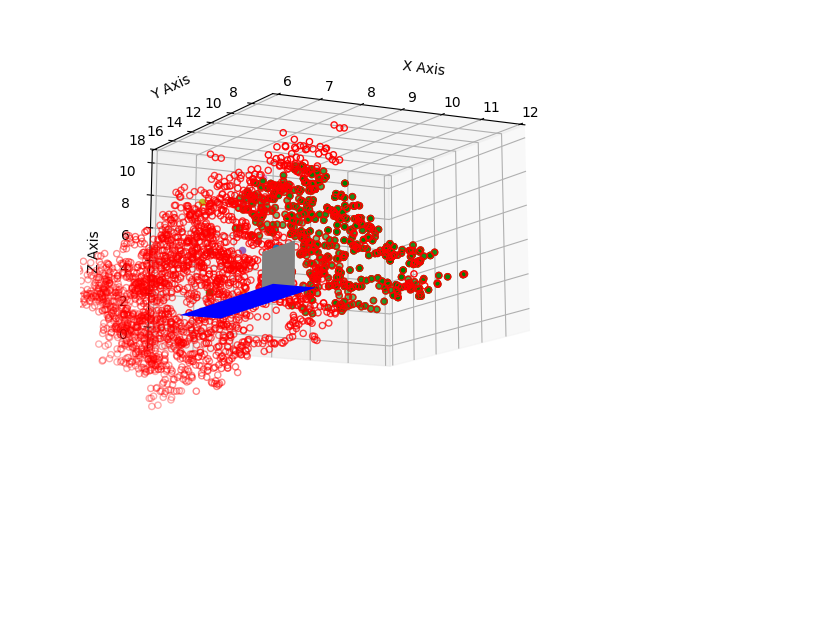

KeyboardInterrupt: 

In [90]:
## plot the vehicle's movement (add other parts as they get finished)    
print("num runs", runs)

# plt.show()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
plt.ion() 

fig.show()
fig.canvas.draw()

ax.set_xlabel('X Axis')
ax.set_ylabel('Y Axis')
ax.set_zlabel('Z Axis')

# index_rem = []

for run in range(runs):
    time_of_loop = t[run]
    
    if run % 20 == 0:
        ax.clear()
        
        try:
            for rows in range(num_row_arms):
                # check if any fruit was picked at this time
                if fruit_removal[rows][3, index_rem[rows]] < time_of_loop:
                    # add the fruit index to be "removed"
                    index_rem[rows] += 1
        except IndexError:
            print("** Index grew faster than it should have? **")
            print("Index to remove:", index_rem)
        
        ax.scatter(fruit.sortedFruit[0,:], fruit.sortedFruit[1,:], fruit.sortedFruit[2,:], facecolors='none', edgecolors='r')
        
        for rows in range(num_row_arms):
            ax.scatter(fruit_removal[rows][0,:index_rem[rows]], fruit_removal[rows][1,:index_rem[rows]], fruit_removal[rows][2,:index_rem[rows]], c='g', marker='o')
            
        q_vehicle = [qv0[run], qv1[run]]
        dr.drawRect(q_vehicle, width_v, length_v) # try and draw the vehicle moving along the orchard
        dr.drawFrame(left_edge[run], back_edge[run], front_edge[run], a[0,0].z_edges_f)

        for rows in range(num_row_arms):
            for count in range(num_arms):
                ax.scatter(a[rows,count].qax[run], a[rows,count].qay[run], a[rows,count].qaz[run])

        ax.set_xlim(6, 12)
        ax.set_ylim(q_v[0], end_row+3)
        
        ax.set_xlabel('X Axis')
        ax.set_ylabel('Y Axis')
        ax.set_zlabel('Z Axis')

        fig.canvas.draw()
        time.sleep(0.005)
       
    
    
fig.show()

